# Bipedal Walker trained with Deep Deterministic Policy Gradients

## Step 0: Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym

## Step 1: Activate the environment and examine state/action spaces

In [2]:
env = gym.make('BipedalWalker-v2')

In [3]:
print(env.observation_space)
print(env.action_space)
print(env.action_space.high)
print(env.action_space.low)

Box(24,)
Box(4,)
[1. 1. 1. 1.]
[-1. -1. -1. -1.]


In [4]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print(state_size)
print(action_size)

24
4


Let's take some random actions in the environment and see what happens...

In [ ]:
for i_episode in range(5):
    observation = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

## Step 2: Create and train the agent

In [5]:
from agents.agent import DDPG
from collections import deque

In [6]:
# Define all hyperparameters here
ACTOR_LR = 1e-4
CRITIC_LR = 3e-4
RANDOM_SEED = 42
MU = 0.0
THETA = 0.15
SIGMA = 0.2
BUFFER_SIZE = 1e6
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3
N_TIME_STEPS = 1
N_LEARN_UPDATES = 1

if tf.test.is_gpu_available():
    DEVICE = "/GPU:0"
else:
    DEVICE = "/device:CPU:0"

In [7]:
agent = DDPG(state_size, action_size, ACTOR_LR, CRITIC_LR,
             RANDOM_SEED, MU, THETA, SIGMA, BUFFER_SIZE, BATCH_SIZE,
             GAMMA, TAU, N_TIME_STEPS, N_LEARN_UPDATES, DEVICE)

Episode 100	Average Score: -110.51
Episode 200	Average Score: -118.05
Episode 300	Average Score: -109.06
Episode 400	Average Score: -109.61
Episode 500	Average Score: -110.94
Episode 600	Average Score: -111.36
Episode 700	Average Score: -104.56
Episode 800	Average Score: -111.88
Episode 900	Average Score: -101.87
Episode 1000	Average Score: -101.92


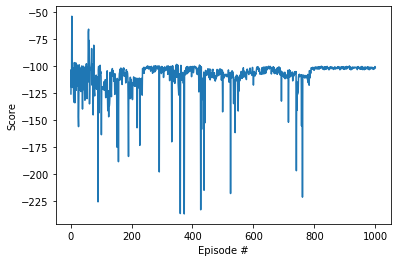

In [8]:
def ddpg(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        t = 0
        
        while(True):
            t += 1
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(t, state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        agent.actor_local.model.save('checkpoint_actor.h5')
        agent.critic_local.model.save('checkpoint_critic.h5')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 300.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            agent.actor_local.model.save('checkpoint_actor.h5')
            agent.critic_local.model.save('checkpoint_critic.h5')
            break
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()